In [74]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import add
from tensorflow.keras import Input, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout

In [75]:
def list_head(l):
    for i in range(5):
        print(l[i])
        print(" ")
    
    print("--------------------------------------------------------------------------------- ")
    print(" ")
        
def dict_head(d):
    dl = list(d.items())
    for i in range(5):
        print(dl[i])
        print(" ")
    
    print("--------------------------------------------------------------------------------- ")
    print(" ")


## Specifying Paths loading tokens into data

In [76]:
train_images_path = 'Flickr8K/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = 'Flickr8K/Flickr8k_text/Flickr_8k.testImages.txt'
images_path = 'Flickr8K/Flicker8k_Images/'

In [77]:
data = open('Flickr8K/Flickr8k_text/Flickr8k.token.txt', encoding = 'utf-8', errors = 'ignore').read().splitlines()


In [78]:
data

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a pai

In [79]:
len(data)

40460

## Dictionary mapping image name to its caption (used for Training )


In [80]:
img_caption_data = {}
for strin in data:
    image_name = strin.split('\t')[0]
    image_name = image_name.split('#')[0]
    captions = strin.split('\t')[1]
    
    captions = captions.lower()                              #Lower casing whole captions
    captions = captions.split()
    
    captions = [word for word in captions if word.isalpha()]
    
    captions = [word for word in captions if len(word)>1]

    captions = ' '.join(captions)
    if image_name in img_caption_data:
        
        img_caption_data[image_name].append(captions)
        
    else:
        img_caption_data[image_name] = [captions]

len(img_caption_data)

8092

In [82]:
img_caption_data

{'1000268201_693b08cb0e.jpg': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70.jpg': ['black dog and spotted dog are fighting',
  'black dog and dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8.jpg': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl with p

## Adding bounding captions with startseq and endseq

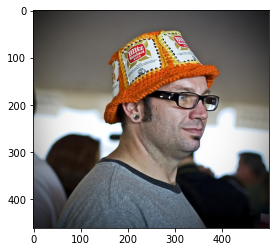

startseq man in an orange hat starring at something endseq
startseq man wears an orange hat and glasses endseq
startseq man with gauges and glasses is wearing blitz hat endseq
startseq man with glasses is wearing beer can crocheted hat endseq
startseq the man with pierced ears is wearing glasses and an orange hat endseq


In [83]:
image_name_list = list(img_caption_data.keys())

for image_name in image_name_list:
    
    for i in range(len(img_caption_data[image_name])):
        
        img_caption_data[image_name][i] = 'startseq ' + img_caption_data[image_name][i] + ' endseq'

image_name = image_name_list[4]
x = plt.imread(images_path+image_name)
plt.imshow(x)
plt.show()
for img in img_caption_data[image_name]:
    print(img)

In [84]:
img_caption_data

{'1000268201_693b08cb0e.jpg': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70.jpg': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8.jpg': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow ends

## Finding max length and loading training captions

In [109]:
max_length = 0
train_img = open(train_images_path,'r',errors='ignore').read().splitlines()
test_img = open(test_images_path, 'r', errors='ignore').read().splitlines()

train_caps = {}

for i in train_img:
    train_caps[i] = img_caption_data[i]

for filename,captions in img_caption_data.items():
    
    for strin in captions:
        if(max_length < len(strin.split())):
            
            max_length = len(strin.split())
            
max_length

33

In [86]:
train_caps

{'2513260012_03d33305cf.jpg': ['startseq black dog is running after white dog in the snow endseq',
  'startseq black dog chasing brown dog through snow endseq',
  'startseq two dogs chase each other across the snowy ground endseq',
  'startseq two dogs play together in the snow endseq',
  'startseq two dogs running through low lying body of water endseq'],
 '2903617548_d3e38d7f88.jpg': ['startseq little baby plays croquet endseq',
  'startseq little girl plays croquet next to truck endseq',
  'startseq the child is playing croquette by the truck endseq',
  'startseq the kid is in front of car with put and ball endseq',
  'startseq the little boy is playing with croquet hammer and ball beside the car endseq'],
 '3338291921_fe7ae0c8f8.jpg': ['startseq brown dog in the snow has something hot pink in its mouth endseq',
  'startseq brown dog in the snow holding pink hat endseq',
  'startseq brown dog is holding pink shirt in the snow endseq',
  'startseq dog is carrying something pink in it

## Filtering out words that occur less than 10 times(avoid overfitting)

In [87]:
word_counts = {}
vocabulary = set()

for img_name in img_caption_data.keys():
        [vocabulary.update(name.split()) for name in img_caption_data[img_name]]
print("Before filtering threshhold Vacab Size is: "+str(len(vocabulary)))
# Threshhold set to 10
for key,values in train_caps.items():
    
    for i in values:
        
        for w in i.split(' '):
            
            word_counts[w] = word_counts.get(w, 0) + 1
vocabulary = [w for w in word_counts if word_counts[w] >= 10]
print("After filtering out words that occur less than 10 times :"+str(len(vocabulary)))

Before filtering threshhold Vacab Size is: 8359
After filtering out words that occur less than 10 times :1643


In [110]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"\.", " . ", text)
    text = re.sub(r"\?", " ? ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"/", " / ", text)
    text = re.sub(r",", " , ", text)
    text = re.sub(r'"', ' " ', text)
    text = re.sub(r"-", " - ", text)
    
    

    text = re.sub(r"[-()\"#/@;:<>{}+=~|.?,]", "", text)
    text = re.sub(' +', ' ', text)
    return text
max_length

33

## Computing embedding index and matrix

In [94]:
embeddings_index = {} 
glove_file = open(os.path.join('Flickr8K/glove.6B.200d.txt'), encoding="utf-8")
for line in glove_file:
    words = line.split()
    word = words[0]
    coeficcients = np.asarray(words[1:], dtype='float32')
    embeddings_index[word] = coeficcients

In [95]:
indx = 1
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
indx2word = {}
word2indx = {}

for w in vocabulary:
    
    word2indx[w] = indx
    indx2word[indx] = w
    indx += 1

vocab_size = len(indx2word) + 1

for word, indx in word2indx.items():
    
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is None:
        continue
    
    else:
        
        embedding_matrix[indx] = embedding_vector


In [97]:
len(embeddings_index)

400000

## Applying InceptionV3 model

In [99]:
import pickle
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical

In [100]:
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

In [38]:
def preprocess(image_name):
    img = image.load_img(images_path+'/'+image_name, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x



In [39]:
from tqdm import tqdm

In [40]:
train_img

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg',
 '488416045_1c6d903fe0.jpg',
 '2644326817_8f45080b87.jpg',
 '218342358_1755a9cce1.jpg',
 '2501968935_02f2cd8079.jpg',
 '2699342860_5288e203ea.jpg',
 '2638369467_8fc251595b.jpg',
 '2926786902_815a99a154.jpg',
 '2851304910_b5721199bc.jpg',
 '3423802527_94bd2b23b0.jpg',
 '3356369156_074750c6cc.jpg',
 '2294598473_40637b5c04.jpg',
 '1191338263_a4fa073154.jpg',
 '2380765956_6313d8cae3.jpg',
 '3197891333_b1b0fd1702.jpg',
 '3119887967_271a097464.jpg',
 '2276499757_b44dc6f8ce.jpg',
 '2506892928_7e79bec613.jpg',
 '2187222896_c206d63396.jpg',
 '2826769554_85c90864c9.jpg',
 '3097196395_ec06075389.jpg',
 '3603116579_4a28a932e2.jpg',
 '3339263085_6db9fd0981.jpg',
 '2532262109_87429a2cae.jpg',
 '2076906555_c20dc082db.jpg',
 '2502007071_82a8c639cf.jpg',
 '3113769557_9edbb8275c.jpg',
 '3325974730_3ee192e4ff.jpg',
 '1655781989_b15ab4cbff.jpg',
 '1662261486_db967930de.jpg',
 '2410562803_56ec09f41c.jpg',
 '2469498117

In [41]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) 
    return fea_vec

encoding_train = {}
for img in tqdm(train_img):
    
    encoding_train[img] = encode(img)
train_features = encoding_train


100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [14:49<00:00,  6.74it/s]


In [54]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img] = encode(img)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:29<00:00,  6.68it/s]


## Saving encodings to local system

In [65]:
# import pickle
# with open('eff_dict.pkl', 'wb') as f:
#     pickle.dump(encoding_train, f)
# with open('eff_dict_test.pkl', 'wb') as f:
#     pickle.dump(encoding_test, f)
        


In [101]:
with open('eff_dict.pkl', 'rb') as f:
    encoding_train = pickle.load(f)
with open('eff_dict_test.pkl', 'rb') as f:
    encoding_test = pickle.load(f)
    

## CNN_LSTM system

In [102]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 33, 200)      328800      ['input_7[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_6[0][0]']                
                                                                                            

In [108]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [105]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [50]:
epochs = 3
batch_size = 3
steps = len(train_text)//batch_size

generator = data_generator(train_text, encoding_train, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/3
2000/2000 [==============================] - 245s 121ms/step - loss: 4.1168
Epoch 2/3
2000/2000 [==============================] - 243s 122ms/step - loss: 3.4160
Epoch 3/3
2000/2000 [==============================] - 260s 130ms/step - loss: 3.2036


In [106]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final






In [107]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

## Predictions

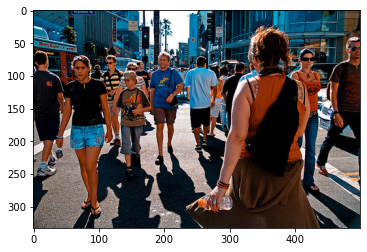

Based on Greedy Search
Image caption :  group of people are standing in front of building
Based on Beam search 
For Beam index = 1, Image caption:  group of people are standing in front of building
For Beam index = 5, Image caption:  group of people standing in front of building
For Beam index = 10, Image caption:  group of people standing in front of building


In [73]:
imglist = list(encoding_test.keys())
img = imglist[41]
image = encoding_test[img].reshape((1,2048))
x=plt.imread(images_path+img)
plt.imshow(x)
plt.show()

print("Based on Greedy Search")
print("Image caption : ",greedySearch(image))
print("Based on Beam search ")
print("For Beam index = 1, Image caption: ",beam_search_predictions(image, beam_index = 1))
print("For Beam index = 5, Image caption: ",beam_search_predictions(image, beam_index = 5))
print("For Beam index = 10, Image caption: ",beam_search_predictions(image, beam_index = 10))


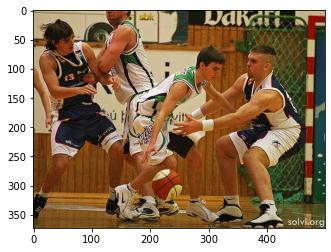

Based on Greedy Search
Image caption :  basketball player in white is being by the player in white
Based on Beam search 
For Beam index = 1, Image caption:  basketball player in white is being by the player in white
For Beam index = 5, Image caption:  group of men playing basketball
For Beam index = 10, Image caption:  the basketball player is about to catch the ball


In [72]:
imglist = list(encoding_test.keys())
img = imglist[9]
image = encoding_test[img].reshape((1,2048))
x=plt.imread(images_path+img)
plt.imshow(x)
plt.show()

print("Based on Greedy Search")
print("Image caption : ",greedySearch(image))
print("Based on Beam search ")
print("For Beam index = 1, Image caption: ",beam_search_predictions(image, beam_index = 1))
print("For Beam index = 5, Image caption: ",beam_search_predictions(image, beam_index = 5))
print("For Beam index = 10, Image caption: ",beam_search_predictions(image, beam_index = 10))


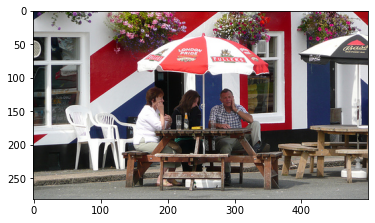

Based on Greedy Search
Image caption :  man in black shirt is sitting on bench with his dog
Based on Beam search 
For Beam index = 1, Image caption:  man in black shirt is sitting on bench with his dog
For Beam index = 5, Image caption:  group of people are standing in front of
For Beam index = 10, Image caption:  group of people standing in front of building


In [71]:
imglist = list(encoding_test.keys())
img = imglist[3]
image = encoding_test[img].reshape((1,2048))
x=plt.imread(images_path+img)
plt.imshow(x)
plt.show()

print("Based on Greedy Search")
print("Image caption : ",greedySearch(image))
print("Based on Beam search ")
print("For Beam index = 1, Image caption: ",beam_search_predictions(image, beam_index = 1))
print("For Beam index = 5, Image caption: ",beam_search_predictions(image, beam_index = 5))
print("For Beam index = 10, Image caption: ",beam_search_predictions(image, beam_index = 10))


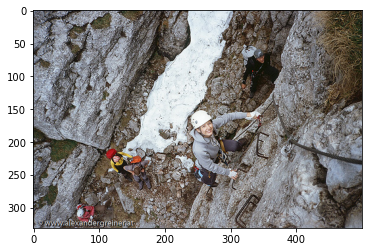

Based on Greedy Search
Image caption :  man is climbing rock face
Based on Beam search 
For Beam index = 1, Image caption:  man is climbing rock face
For Beam index = 5, Image caption:  man climbing rock face
For Beam index = 10, Image caption:  rock climber climbing rock face


In [70]:
imglist = list(encoding_test.keys())
img = imglist[31]
image = encoding_test[img].reshape((1,2048))
x=plt.imread(images_path+img)
plt.imshow(x)
plt.show()

print("Based on Greedy Search")
print("Image caption : ",greedySearch(image))
print("Based on Beam search ")
print("For Beam index = 1, Image caption: ",beam_search_predictions(image, beam_index = 1))
print("For Beam index = 5, Image caption: ",beam_search_predictions(image, beam_index = 5))
print("For Beam index = 10, Image caption: ",beam_search_predictions(image, beam_index = 10))


## Computing the Average BLEU scores for Greedy search and beam search

In [1]:
scorelist_greedy=[]
scorelist_beam=[]

# We calculate scores on first 50 images
for t in tqdm(test_img[:50]):
    reference = []
    print(t)
    for i in range(5):
        tmp = test_caps[t][i].split()
        tmp.remove('startseq')
        print(tmp)
        tmp.remove('endseq')
        reference.append(tmp)
         
        
    
    image = encoding_test[t].reshape((1,2048))
    cand_greedy = greedySearch(image).split()
    cand_beam = beam_search_predictions(image, beam_index = 1).split()
    score_g = sentence_bleu(reference, cand_greedy)
    scorelist_greedy.append(score_g)
    score_b = sentence_bleu(reference, cand_beam)
    scorelist_beam.append(score_b)


avg_BLEU_greedy = sum(scorelist_greedy)/len(scorelist_greedy)
avg_BLEU_beam = sum(scorelist_beam)/len(scorelist_beam)

print(" Avg BLEU for greedySearch prediction : "+str(avg_BLEU_greedy))
print(" Avg BLEU for BeamSearch prediction : "+str(avg_BLEU_beam))

 Avg BLEU for greedySearch prediction : 0.49812
 Avg BLEU for BeamSearch prediction : 0.521303
